In [148]:
import pandas as pd
import numpy as np
import NDCG as ndcg
import MHR as mhr
import sys
import types
ndcg.reload_package(mhr)
from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from time import time
%matplotlib inline

loading MHR


In [149]:
reviews_features = pd.read_csv('data/eletronic_sample_counts.csv.gz')
df_agg = reviews_features[['word_count','asin']].groupby(['asin']).agg(['count','mean'])
df_agg['word_count'].sort_values('count',ascending=False).head(10)

,count,mean
asin,,
B00BGA9WK2,351,253.079772
B00A3YN0Z0,219,104.237443
B0074BW614,201,451.900498
B00CMQTVK0,165,334.696970
B0094NY3R0,147,232.972789
B0045FM6SU,140,374.121429
B00DVFLJDS,139,352.625899
B009LL9VDG,133,424.443609
B002C7481G,132,501.636364


In [150]:
#list_asin = ['B00BGA9WK2','B00A3YN0Z0','B0074BW614','B00CMQTVK0','B0094NY3R0','B0045FM6SU','B00DVFLJDS']
#reviews_features = reviews_features[reviews_features.asin.isin(list_asin)]
#reviews_features.drop('powerWithStar', axis=1, inplace=True)
#reviews_features,ndcg_mhr = mhr.executeFromDf(reviews_features)
#reviews_features[reviews_features['asin']=='B00001WRSJ']

reviews_features,ndcg_mhr = mhr.executeFromDf(reviews_features)

#reviews_features.shape
#reviews_features.to_csv('data/eletronic_sample_counts.csv.gz', compression='gzip')

product=1400532655 ndcg=0.939337991541 (0.939337991541)
product=B00000J061 ndcg=0.946442955431 (0.953547919321)
product=B00001P4ZH ndcg=0.942720929481 (0.93527687758)
product=B00001WRSJ ndcg=0.952054205233 (0.980054032489)
product=B000031KIM ndcg=0.956594496025 (0.974755659196)
product=B00004SB92 ndcg=0.949214627958 (0.912315287623)
product=B00004THCZ ndcg=0.949144745689 (0.948725452073)
product=B00004XOM3 ndcg=0.94925446214 (0.950022477297)
product=B00004ZCJE ndcg=0.944047221494 (0.902389296327)
product=B000053HC5 ndcg=0.932487627042 (0.828451276969)
product=B000053HH5 ndcg=0.938134255022 (0.994600534829)
product=B00005LEN4 ndcg=0.94309960484 (0.997718452832)
product=B000062VUO ndcg=0.934582472212 (0.83237688068)
product=B00006B7DA ndcg=0.936405196655 (0.960100614412)
product=B00006HMPK ndcg=0.938724600335 (0.971196251856)
product=B00006I53S ndcg=0.941630720088 (0.985222516376)
product=B00006I53X ndcg=0.941494914586 (0.93932202656)
product=B00006IS4X ndcg=0.940286766679 (0.91974825225

In [151]:
#len(reviews_features)
np.mean(ndcg.calc_ndcg(reviews_features,'powerWithStar',5))
#reviews_features[['helpfulness','tot','powerWithStar']]

0.89246692285801732

PageRank ndcg=0.87155497918
HITs ndcg=0.871770213457
MHR ndcg=0.892466922858
SVM ndcg=0.671172961415


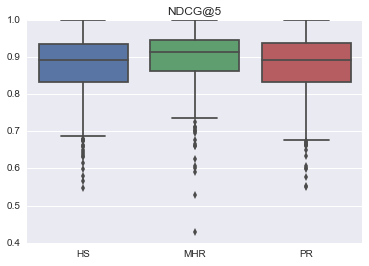

In [152]:
import seaborn as sns
k=5



ndcg_pr=ndcg.calc_ndcg(reviews_features,'pageRank',k) 
corr_pr=ndcg.calc_corr(reviews_features,'pageRank') 
print "PageRank ndcg="+str(np.mean(ndcg_pr))

ndcg_hs=ndcg.calc_ndcg(reviews_features,'hits',k) 
corr_hs=ndcg.calc_corr(reviews_features,'hits') 
print "HITs ndcg="+str(np.mean(ndcg_hs))

ndcg_mhr=ndcg.calc_ndcg(reviews_features,'powerWithStar',k) 
corr_mhr=ndcg.calc_corr(reviews_features,'powerWithStar') 
print "MHR ndcg="+str(np.mean(ndcg_mhr))

ndcg_svm=ndcg.calc_ndcg(pd.read_csv('data/best_prediction_svm.csv'),'svm',k) 
corr_svm=ndcg.calc_corr(pd.read_csv('data/best_prediction_svm.csv'),'svm') 

print "SVM ndcg="+str(np.mean(ndcg_svm))


tip={}
tip['HS']=ndcg_hs
tip['PR']=ndcg_pr
tip['MHR']=ndcg_mhr
#tip['SVM']=ndcg_svm
df = pd.DataFrame(tip)
ax = sns.boxplot(data=df)
#ax = sns.swarmplot(data=df, color=".25")
ax.set_title('NDCG@'+str(k))

[None, None, None, None, None, None, None, None, None, None, None, None]

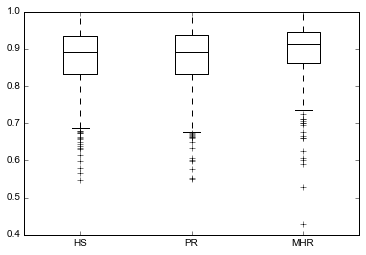

In [155]:

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt 
%matplotlib inline
# Create a figure instance

# Create an axes instance

data_to_plot = [ndcg_hs, ndcg_pr, ndcg_mhr]

# Create the boxplot
#plt.boxplot(data_to_plot, labels=["HR","PR","MHR"])





bp = plt.boxplot(data_to_plot, labels=["HS","PR","MHR"])
plt.setp(bp['boxes'], linewidth=1, color='black')
plt.setp(bp['fliers'], linewidth=1, color='black')
plt.setp(bp['medians'], linewidth=1, color='black')
plt.setp(bp['whiskers'], linewidth=1, color='black')


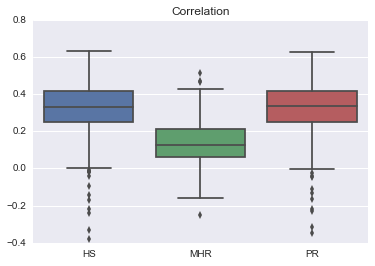

In [154]:
tip={}
tip['PR']=corr_pr
tip['HS']=corr_hs
tip['MHR']=corr_mhr
dftip=pd.DataFrame(tip)
dftip.head()
ax = sns.boxplot(data=dftip)
#ax = sns.swarmplot(data=dftip, color=".25")

ax.set_title('Correlation')